## Scanner template

This notebook contains the basic syntax required to run a chi2 scan

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
import numpy as np
import time
# our own modules
from lace.cosmo import camb_cosmo
from lace.emulator import gp_emulator
from lace.emulator import p1d_archive
from lace_manager.data import data_MPGADGET
from lace_manager.likelihood import lya_theory
from lace_manager.likelihood import likelihood
from lace_manager.sampler import iminuit_minimizer

### Set up mock data

Begin by picking a simulation to use as mock data, and creating a corresponding data object

In [2]:
# specify simulation to use to generate synthetic data
test_sim_label="central"
if type(test_sim_label)==int:
    drop_sim_number=test_sim_label
    print('will drop sim number {} from emulator'.format(drop_sim_number))
else:
    drop_sim_number=None

In [3]:
# specify simulation suite and P1D mesurements
basedir="/lace/emulator/sim_suites/Australia20/"
z_max=4.5
emu_type="polyfit"
data=data_MPGADGET.P1D_MPGADGET(basedir=basedir,sim_label=test_sim_label,
                                zmax=z_max,polyfit=(emu_type=="polyfit"))

H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = -5.5511E-17, Omega_nu h^2 = 0.0000E+00, A_s = 2.0061E-09, n_s = 9.6757E-01, alpha_s = 0.0000E+00


### Emulator and training set

Create a set of training data to train an emulator

In [4]:
# Set up emulator training set
archive=p1d_archive.archiveP1D(basedir=basedir,drop_sim_number=drop_sim_number,z_max=z_max,
                            drop_tau_rescalings=True,drop_temp_rescalings=True,)

In [5]:
paramList=['mF', 'sigT_Mpc', 'gamma', 'kF_Mpc', 'Delta2_p', 'n_p']
kmax_Mpc=8
emu=gp_emulator.GPEmulator(basedir,z_max=z_max,
                                verbose=False,paramList=paramList,train=True,
                                asymmetric_kernel=True,rbf_only=True,
                                emu_type=emu_type,passarchive=archive,
                                kmax_Mpc=kmax_Mpc)

 /Users/font/opt/anaconda3/envs/lace_env/lib/python3.8/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Training GP on 330 points
GPs optimised in 0.30 seconds


### For different values of $n_s$ will minimize over ($\Delta^2_\star$, $\ln \tau_0$)

In [6]:
free_param_names=["ln_tau_0","Delta2_star"]
prior=0.5

In [9]:
scan_N=20
scan_ns=np.linspace(0.93,1.0,scan_N)
scan_log_like=np.empty_like(scan_ns)

In [10]:
for i in range(scan_N):
    cosmo_fid=camb_cosmo.get_cosmology(ns=scan_ns[i])
    camb_cosmo.print_info(cosmo_fid)
    theory=lya_theory.LyaTheory(zs=data.z,emulator=emu,cosmo_fid=cosmo_fid)
    like=likelihood.Likelihood(data=data,theory=theory,
                            free_param_names=free_param_names,
                            prior_Gauss_rms=prior,include_CMB=False)
    minimizer = iminuit_minimizer.IminuitMinimizer(like)
    minimizer.minimize(compute_hesse=False)
    scan_log_like[i]=minimizer.minimizer.fval

H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = 0.0000E+00, Omega_nu h^2 = 0.0000E+00, A_s = 2.1000E-09, n_s = 9.3000E-01, alpha_s = 0.0000E+00
will run migrad
H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = 0.0000E+00, Omega_nu h^2 = 0.0000E+00, A_s = 2.1000E-09, n_s = 9.3368E-01, alpha_s = 0.0000E+00
will run migrad
H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = 0.0000E+00, Omega_nu h^2 = 0.0000E+00, A_s = 2.1000E-09, n_s = 9.3737E-01, alpha_s = 0.0000E+00
will run migrad
H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = 0.0000E+00, Omega_nu h^2 = 0.0000E+00, A_s = 2.1000E-09, n_s = 9.4105E-01, alpha_s = 0.0000E+00
will run migrad
H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = 0.0000E+00, Omega_nu h^2 = 0.0000E+00, A_s = 2.1000E-09, n_s = 9.4474E-01, alpha_s = 0.0000E+00
will run migrad
H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Om

Text(0.5, 0, '$n_s$')

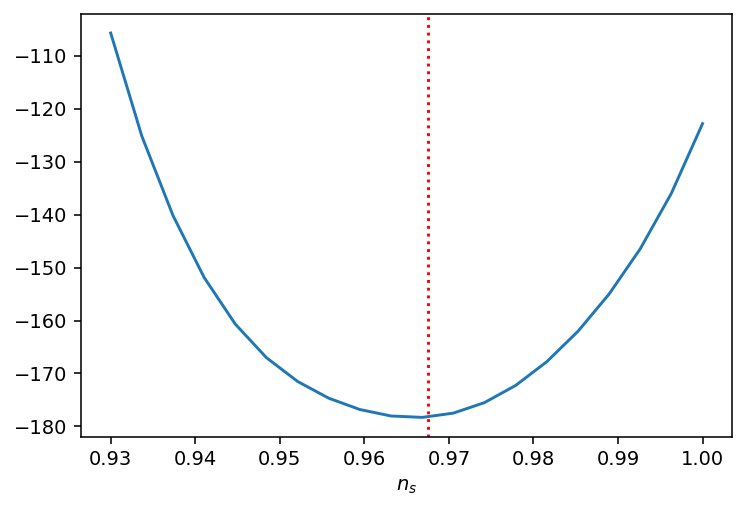

In [11]:
plt.plot(scan_ns,scan_log_like)
plt.axvline(x=like.truth['ns'],ls=':',color='red')
plt.xlabel(r'$n_s$')

### For different values of ($A_s$, $n_s$) will minimize over ($\ln \tau_0$)

In [17]:
#free_param_names=["ln_tau_0","ln_tau_1","ln_gamma_0","ln_gamma_1"]
free_param_names=["ln_tau_0"]
prior=0.5

In [18]:
def get_max_log_like(As,ns):
    cosmo_fid=camb_cosmo.get_cosmology(As=As,ns=ns)
    camb_cosmo.print_info(cosmo_fid)
    theory=lya_theory.LyaTheory(zs=data.z,emulator=emu,cosmo_fid=cosmo_fid)
    like=likelihood.Likelihood(data=data,theory=theory,
                            free_param_names=free_param_names,
                            prior_Gauss_rms=prior,include_CMB=False)
    minimizer = iminuit_minimizer.IminuitMinimizer(like)
    minimizer.minimize(compute_hesse=False)
    return minimizer.minimizer.fval

In [19]:
# test computing time for one minimization
start = time.time()
get_max_log_like(As=2e9,ns=0.96)
end = time.time()
print('{:.4f} seconds to minimize'.format(end-start))

H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = 0.0000E+00, Omega_nu h^2 = 0.0000E+00, A_s = 2.0000E+09, n_s = 9.6000E-01, alpha_s = 0.0000E+00
will run migrad
0.8292 seconds to minimize


In [20]:
scan_N=10
min_As_e9=1.7
max_As_e9=2.5
min_ns=0.93
max_ns=1.0
Nj=complex(0,scan_N)
scan_As_e9, scan_ns = np.mgrid[min_As_e9:max_As_e9:Nj, min_ns:max_ns:Nj]
scan_log_like = np.empty_like(scan_As_e9)

In [21]:
for i in range(scan_N):
    for j in range(scan_N):
        As=scan_As_e9[i,j]*1e-9
        print(i,j,As)
        cosmo_fid=camb_cosmo.get_cosmology(As=As,ns=scan_ns[i,j])
        camb_cosmo.print_info(cosmo_fid)
        theory=lya_theory.LyaTheory(zs=data.z,emulator=emu,cosmo_fid=cosmo_fid)
        like=likelihood.Likelihood(data=data,theory=theory,
                            free_param_names=free_param_names,
                            prior_Gauss_rms=prior,include_CMB=False)
        minimizer = iminuit_minimizer.IminuitMinimizer(like)
        minimizer.minimize(compute_hesse=False)
        scan_log_like[i,j]=minimizer.minimizer.fval

0 0 1.7000000000000001e-09
H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = 0.0000E+00, Omega_nu h^2 = 0.0000E+00, A_s = 1.7000E-09, n_s = 9.3000E-01, alpha_s = 0.0000E+00
will run migrad
0 1 1.7000000000000001e-09
H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = 0.0000E+00, Omega_nu h^2 = 0.0000E+00, A_s = 1.7000E-09, n_s = 9.3778E-01, alpha_s = 0.0000E+00
will run migrad
0 2 1.7000000000000001e-09
H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = 0.0000E+00, Omega_nu h^2 = 0.0000E+00, A_s = 1.7000E-09, n_s = 9.4556E-01, alpha_s = 0.0000E+00
will run migrad
0 3 1.7000000000000001e-09
H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = 0.0000E+00, Omega_nu h^2 = 0.0000E+00, A_s = 1.7000E-09, n_s = 9.5333E-01, alpha_s = 0.0000E+00
will run migrad
0 4 1.7000000000000001e-09
H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = 0.0000E+00, Omega_nu h

will run migrad
3 8 1.9666666666666665e-09
H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = 0.0000E+00, Omega_nu h^2 = 0.0000E+00, A_s = 1.9667E-09, n_s = 9.9222E-01, alpha_s = 0.0000E+00
will run migrad
3 9 1.9666666666666665e-09
H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = 0.0000E+00, Omega_nu h^2 = 0.0000E+00, A_s = 1.9667E-09, n_s = 1.0000E+00, alpha_s = 0.0000E+00
will run migrad
4 0 2.0555555555555556e-09
H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = 0.0000E+00, Omega_nu h^2 = 0.0000E+00, A_s = 2.0556E-09, n_s = 9.3000E-01, alpha_s = 0.0000E+00
will run migrad
4 1 2.0555555555555556e-09
H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = 0.0000E+00, Omega_nu h^2 = 0.0000E+00, A_s = 2.0556E-09, n_s = 9.3778E-01, alpha_s = 0.0000E+00
will run migrad
4 2 2.0555555555555556e-09
H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = 0.0000

will run migrad
7 6 2.322222222222222e-09
H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = 0.0000E+00, Omega_nu h^2 = 0.0000E+00, A_s = 2.3222E-09, n_s = 9.7667E-01, alpha_s = 0.0000E+00
will run migrad
7 7 2.322222222222222e-09
H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = 0.0000E+00, Omega_nu h^2 = 0.0000E+00, A_s = 2.3222E-09, n_s = 9.8444E-01, alpha_s = 0.0000E+00
will run migrad
7 8 2.322222222222222e-09
H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = 0.0000E+00, Omega_nu h^2 = 0.0000E+00, A_s = 2.3222E-09, n_s = 9.9222E-01, alpha_s = 0.0000E+00
will run migrad
7 9 2.322222222222222e-09
H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = 0.0000E+00, Omega_nu h^2 = 0.0000E+00, A_s = 2.3222E-09, n_s = 1.0000E+00, alpha_s = 0.0000E+00
will run migrad
8 0 2.4111111111111113e-09
H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = 0.0000E+00

Text(0, 0.5, 'ns')

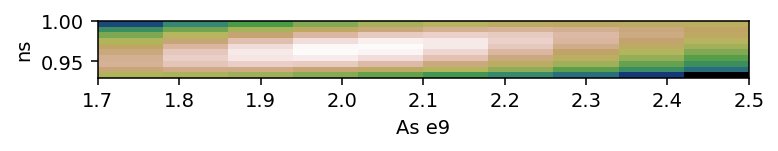

In [26]:
#plt.figure(figsize=[6,8])
plt.imshow(np.rot90(scan_log_like), cmap=plt.cm.gist_earth_r,extent=[min_As_e9, max_As_e9, min_ns, max_ns])
plt.xlabel('As e9')
plt.ylabel('ns')